In [69]:
from coc131_cw import COC131
import matplotlib.pyplot as plt
import numpy as np
#initialise the class containing the necessary methods
coc131 = COC131()

<h1 style="text-align:center">Q1 - loading the data</h1>

Q1 does 2 things: first it loads all the data from the dataset, then it checks if the filename variable is not None. if it has a value, then it calls a static function to get the data for that individual file.

In [70]:
#load the data into variables coc131.x and coc131.y
coc131.q1()

Skipping complete data processing step


(array([0.]), '')

In [73]:
#testing with an input filename
coc131.q1(r"..\dataset\EuroSAT_RGB\AnnualCrop\AnnualCrop_1.jpg")

Skipping complete data processing step


(array([149., 121., 120., ..., 106.,  94., 104.], shape=(3072,)), 'AnnualCrop')

<h1 style="text-align:center">Q2 - standardising the data</h1>

Every column in the data gets standardised to have mean=0 and std=2.5. The standardisation of data will help during the learning process, because every dimension can be treated more equally, and the learning rate can remain reasonable.

In [74]:
scaler, standardised_data = coc131.q2(coc131.x)
print(scaler)
print(standardised_data.shape)

StandardScaler()
(27000, 3072)


Using the first 3 features, I created some histograms to show how the standardisation affects the shape of the data. The histograms demonstrate that the overall shape and outliers are not affected, only the width has been rescaled. Some bars are slightly different because the bins have been rescaled.

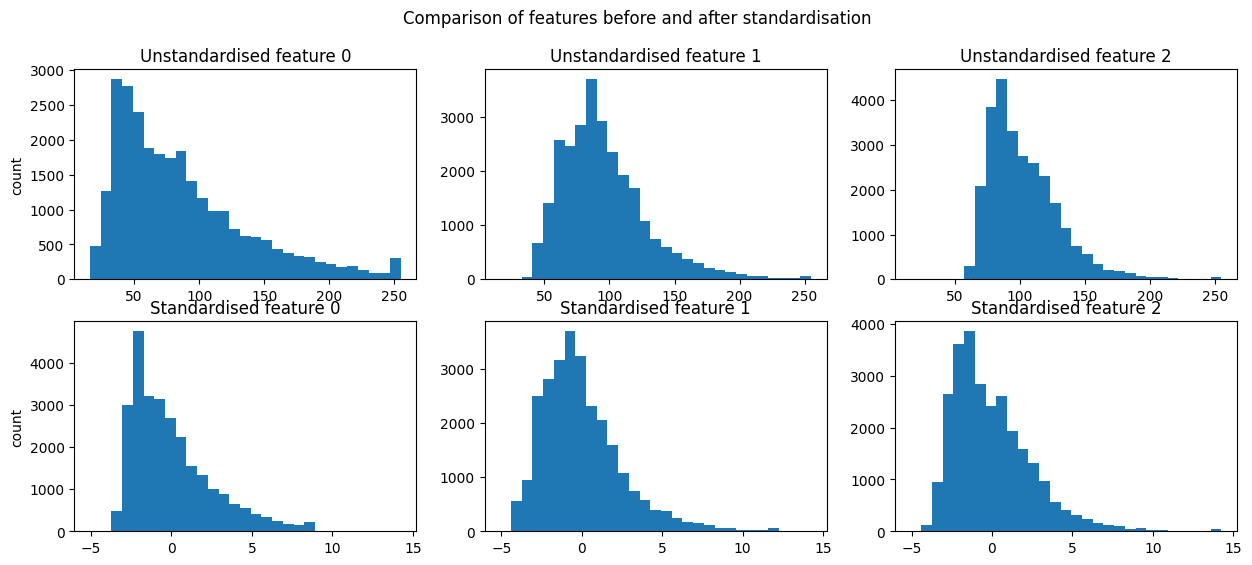

In [ ]:
features = [0,1,2]
fig, axes = plt.subplots(2, len(features), figsize=(15, 6))
for i, feature in enumerate(features):
    bins_raw = np.linspace(coc131.x.min(), coc131.x.max(), 30)
    bins_std = np.linspace(standardised_data.min(), standardised_data.max(), 30)
    axes[0,i].hist(coc131.x[:, feature], bins=bins_raw)
    axes[0, i].set_title(f"Unstandardised feature {feature}")
    axes[1,i].hist(standardised_data[:, feature], bins=bins_std)
    axes[1, i].set_title(f"Standardised feature {feature}")
axes[0, 0].set_ylabel("count")
axes[1, 0].set_ylabel("count")
plt.suptitle("Comparison of features before and after standardisation")
plt.show()

The boxplot below further demonstrates how the standardisation centers everything on 0 while maintaining outliers, relative to the new bounds.

C:\Users\A\AppData\Local\Temp\ipykernel_7484\3270605288.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[0].boxplot(
C:\Users\A\AppData\Local\Temp\ipykernel_7484\3270605288.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[1].boxplot(


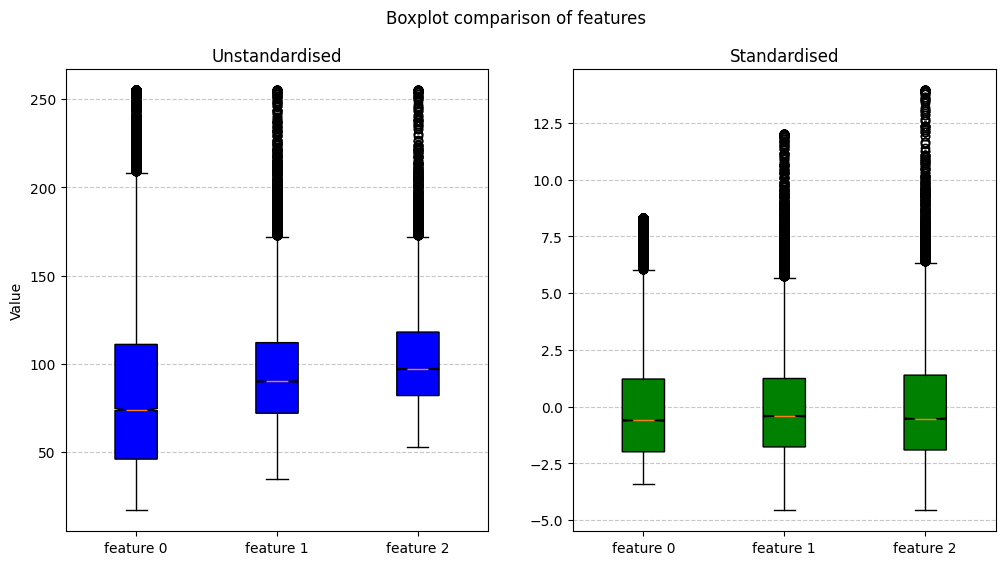

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
raw_boxes = [coc131.x[:, feature] for feature in features]
axes[0].boxplot(
        raw_boxes,
        labels=[f"feature {feature}" for feature in features],
        notch=True,
        patch_artist=True,
        boxprops=dict(facecolor="blue")
)
axes[0].set_title("Unstandardised")
axes[0].set_ylabel("Value")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

std_boxes = [standardised_data[:, feature] for feature in features]
axes[1].boxplot(
        std_boxes,
        labels=[f"feature {feature}" for feature in features],
        notch=True,
        patch_artist=True,
        boxprops=dict(facecolor="green")
)
axes[1].set_title("Standardised")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

plt.suptitle("Boxplot comparison of features")
plt.show()

By using principal component analysis, the data can be collapsed into 2D, showing how the data is more spread out after standardisation. This could be because before standardisation, certain features were showing larger variance, whereas now there is a more balanced structure.

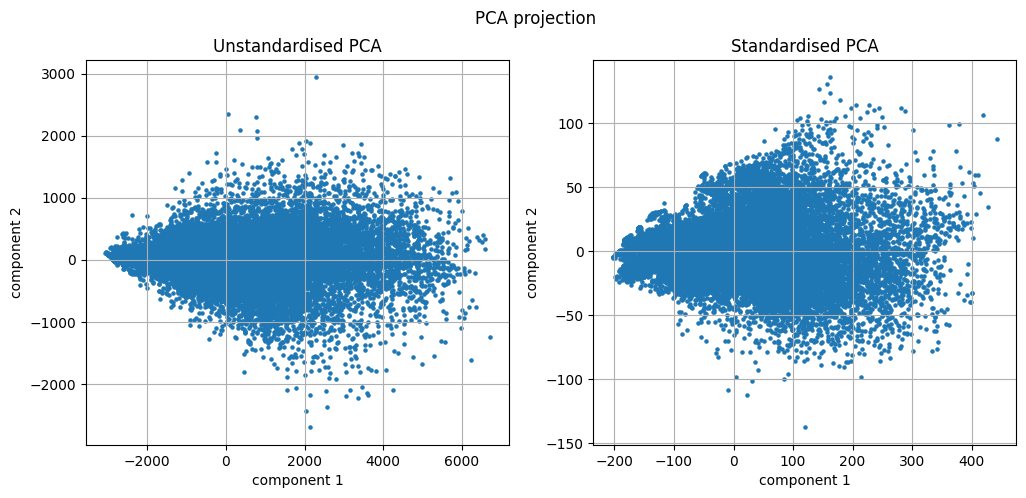

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
unstandardised_pca = pca.fit_transform(coc131.x)
standardised_pca = pca.fit_transform(standardised_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
#unstandardised graph
ax1.scatter(unstandardised_pca[:, 0], unstandardised_pca[:, 1], s=5)
ax1.set_title("Unstandardised PCA")
ax1.set_xlabel("component 1")
ax1.set_ylabel("component 2")
ax1.grid(True)
#standardised graph
ax2.scatter(standardised_pca[:, 0], standardised_pca[:, 1], s=5)
ax2.set_title("Standardised PCA")
ax2.set_xlabel("component 1")
ax2.set_ylabel("component 2")
ax2.grid(True)

plt.suptitle("PCA projection")
plt.show()

<h1 style="text-align:center">Q3 - hyperparameter discovery process</h1>


The following function is just for visualisation:

In [ ]:
def plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparams):
    epochs = list(range(1, len(loss)+1))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    #plot loss
    fig.suptitle(f"Hyperparams: {hyperparams}")
    ax1.plot(epochs, loss, label='Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training loss')
    ax1.legend()
    ax1.grid(True)
    #plot accuracies
    ax2.plot(epochs, train_acc, label='Training accuracy')
    ax2.plot(epochs, test_acc, label='Testing accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Training and testing accuracy')
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

Initially, I wanted to create a custom grid search to do hyperparameter optimisation within q3. However, instead I decided to intelligently choose hyperparameters and run q3 multiple times, visualising the results each time. 

I first tried a fairly deep architecture with 2 hidden layers of 100 nodes each, giving the network enough capacity to model complex land‐use patterns without increasing the parameter count too much. I chose SGD to get finer control over the convergence behaviour, such as by using momentum, and I chose alpha=1e-4 to discourage overfitting.

In [ ]:
hyperparam = {
            'hidden_layer_sizes': (100,100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 32,
            'momentum': 0.8,
            'max_iter'         : 50
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=32, hidden_layer_sizes=(100, 100), max_iter=1,
              momentum=0.8, random_state=0, solver='sgd', warm_start=True)
[np.float64(1.4811143442982795), np.float64(1.174854277777087), np.float64(1.0586250321462678), np.float64(0.9748619238140878), np.float64(0.9092385849430655), np.float64(0.8518365368757179), np.float64(0.7997706323850434), np.float64(0.7519463473763314), np.float64(0.7109159741604887), np.float64(0.6704946919873328), np.float64(0.6332601824059011), np.float64(0.5995081232521745), np.float64(0.5691622478956181), np.float64(0.5378293441997163), np.float64(0.5109344727148689), np.float64(0.4861667209046562), np.float64(0.46109634686474243), np.float64(0.43726297868878133), np.float64(0.4173601518161885), np.float64(0.3973402488874155), np.float64(0.38076697667068016), np.float64(0.36476864639192563), np.float64(0.3485531215882849), np.float64(0.33632959268748497), np.float64(0.320487671125532), np.float64(0.308494525246948), np.float64(0.29400

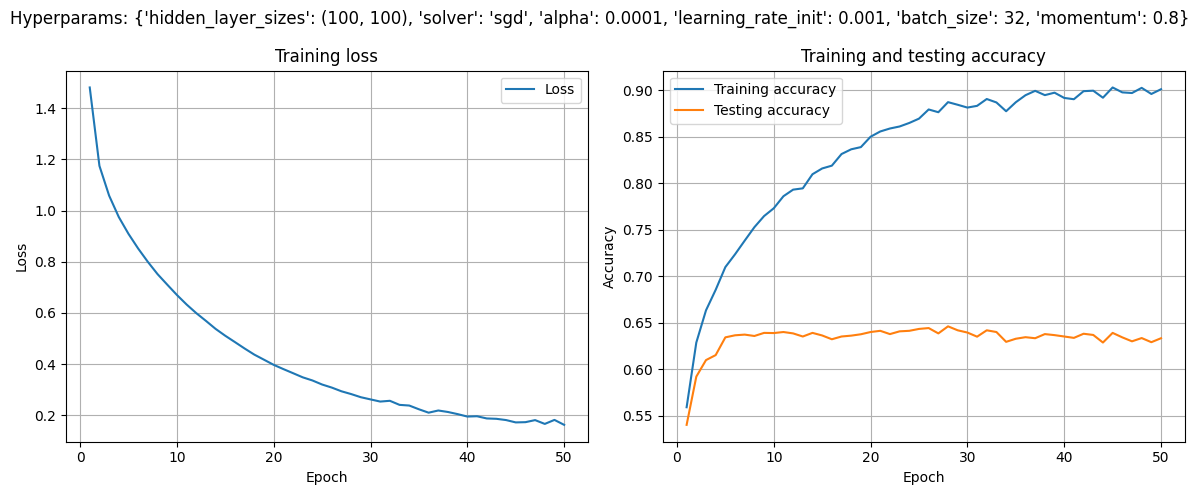

In [18]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

The results were good, reaching a testing accuracy of around 0.64 and a training accuracy of 0.9.

I then tried the Adam solver, to make use of the adaptive learning and in built momentum. I wanted to see if the results would converge faster, so I decreased the amount of epochs in anticipation of this.

In [5]:
hyperparam = {
            'hidden_layer_sizes': (100,100),
            'solver'           : 'adam',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 32,
            'max_iter'         : 25
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=32, hidden_layer_sizes=(100, 100), max_iter=1,
              random_state=0, warm_start=True)
[np.float64(1.8786306745453416), np.float64(1.4725056881149836), np.float64(1.2631788709449783), np.float64(1.1414110463279237), np.float64(1.0545724123814755), np.float64(0.9991340879283686), np.float64(0.9196366006194687), np.float64(0.8697481000521421), np.float64(0.8262342860823547), np.float64(0.7831720794995937), np.float64(0.7433484134595286), np.float64(0.7109756352885014), np.float64(0.6931738540766937), np.float64(0.6510914880929275), np.float64(0.6300071605039227), np.float64(0.6131002995305433), np.float64(0.5948240403595191), np.float64(0.5866189655959808), np.float64(0.5647711422171223), np.float64(0.5494207691175289), np.float64(0.5412174630838344), np.float64(0.5261767617815363), np.float64(0.5277267850936214), np.float64(0.509883854084442), np.float64(0.4901910781408905)]
[0.5275462962962963, 0.5613425925925926, 0.6081481481481481, 0.6468981481481482, 

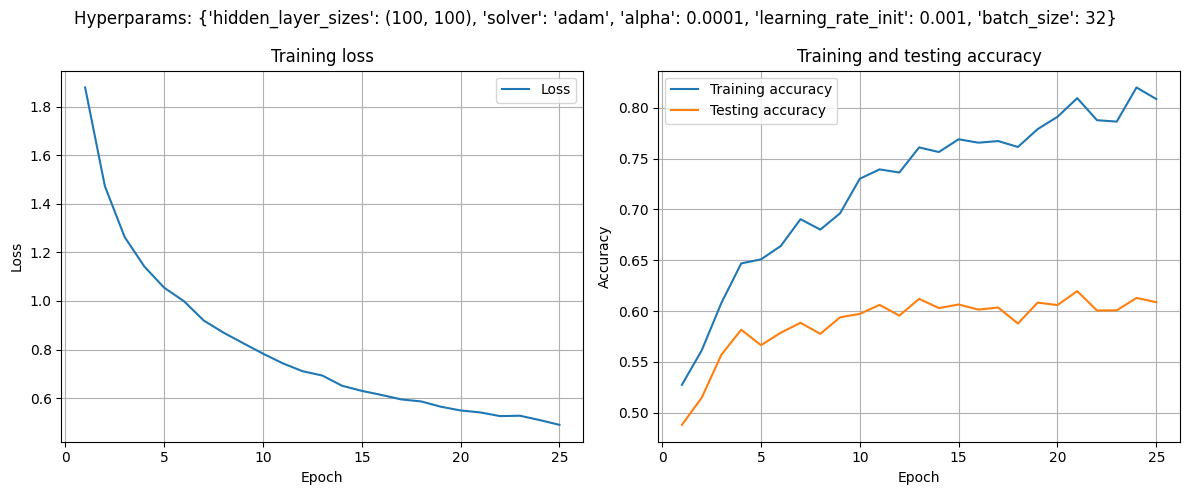

In [6]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

These results were a little dissapointing, since I was expecting Adam to achieve a better testing accuracy. I modified the hyperparameters to use a larger hidden layer structure, a lower learning rate, and a larger batch, but it still only reached 0.63 testing accuracy:

In [21]:
hyperparam = {
            'hidden_layer_sizes': (200, 100),
            'activation'       : 'relu',
            'solver'           : 'adam',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-4,
            'batch_size'       : 64,
            'max_iter'         : 50
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=64, hidden_layer_sizes=(200, 100),
              learning_rate_init=0.0001, max_iter=1, random_state=0,
              warm_start=True)
[np.float64(1.6306686641751522), np.float64(1.2262276109273105), np.float64(1.0741586946652937), np.float64(0.9655538645491955), np.float64(0.8827711882401287), np.float64(0.8087248351557563), np.float64(0.7482523762767238), np.float64(0.695827943981005), np.float64(0.6508262570703677), np.float64(0.6104507091595357), np.float64(0.5756914238191466), np.float64(0.538630939270389), np.float64(0.5117616690964376), np.float64(0.4831876644782034), np.float64(0.4605307351295029), np.float64(0.43600917261709776), np.float64(0.41709566615440796), np.float64(0.3962687834578128), np.float64(0.3817592507478), np.float64(0.3631529517624519), np.float64(0.3535996319078418), np.float64(0.34418895644228775), np.float64(0.32723860924854997), np.float64(0.3140480652325345), np.float64(0.3099904284557907), np.float64(0.29902080686347043), np.floa

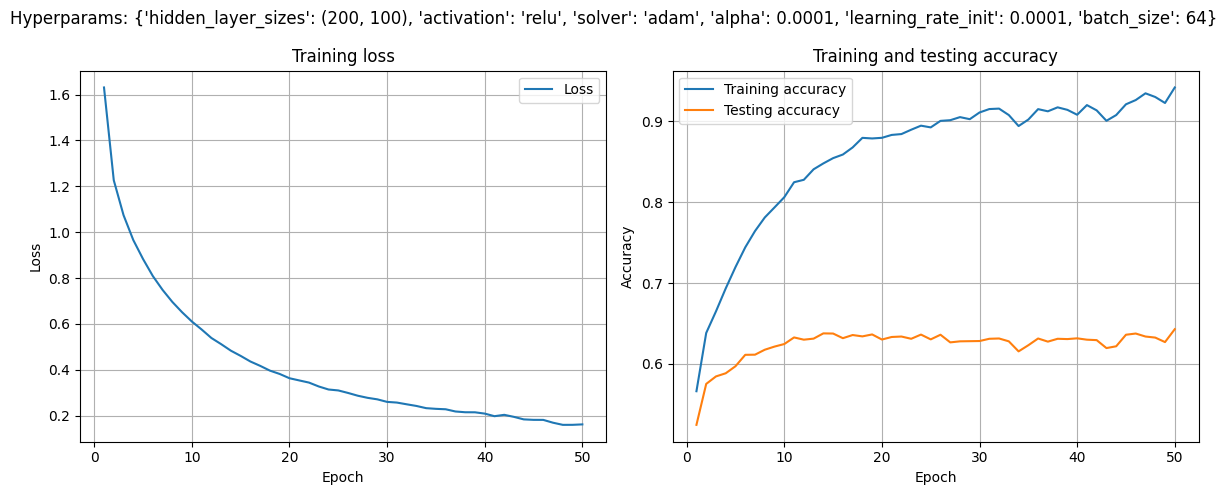

In [22]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

I decided to stick with SGD, because it seemed to get better results. I used a higher batch size and I was able to get good results, with 0.65 testing accuracy.

In [9]:
hyperparam = {
            'hidden_layer_sizes': (100, 100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 64,
            'momentum': 0.8,
            'max_iter'         : 25
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=64, hidden_layer_sizes=(100, 100), max_iter=1,
              momentum=0.8, random_state=0, solver='sgd', warm_start=True)
[np.float64(1.5505835661725444), np.float64(1.2311000924090125), np.float64(1.1187917551435047), np.float64(1.0434189650241728), np.float64(0.983625863557231), np.float64(0.9329365326218306), np.float64(0.8895950351843882), np.float64(0.8500231645169815), np.float64(0.8143885867002938), np.float64(0.7814102723105981), np.float64(0.7501341178618405), np.float64(0.7209924131457977), np.float64(0.694708201637206), np.float64(0.6691623335263065), np.float64(0.6451878662070706), np.float64(0.6220079336998), np.float64(0.5994013392994856), np.float64(0.5780635420607462), np.float64(0.5580023955283157), np.float64(0.5384596795398049), np.float64(0.520094395377831), np.float64(0.50162610255047), np.float64(0.48426434407141017), np.float64(0.46809092278219866), np.float64(0.452436435457185)]
[0.544212962962963, 0.606574074074074, 0.6338888888888888, 

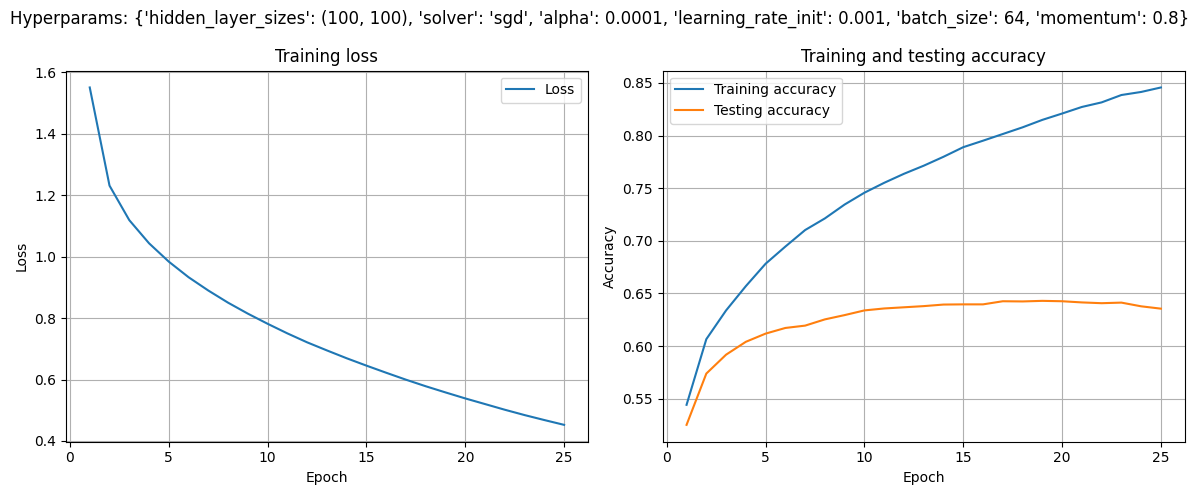

In [10]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

I then tried to modify the hyperparameters to encourage exploration outside of local minima, by keeping a good learning rate and increasing momentum, as well as increasing the hidden layer structure. However, this did not get better results:

In [17]:
hyperparam = {
            'hidden_layer_sizes': (200, 100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 128,
            'momentum': 0.99,
            'max_iter'         : 50
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=128, hidden_layer_sizes=(100, 50, 50), max_iter=1,
              momentum=0.99, random_state=0, solver='sgd', warm_start=True)
[np.float64(1.612904551888361), np.float64(1.2499381860753263), np.float64(1.1177596866706712), np.float64(1.037949431117398), np.float64(0.9709546886575473), np.float64(0.9154586604417022), np.float64(0.8671854341741224), np.float64(0.8318075516244346), np.float64(0.812002818803974), np.float64(0.7650741665506672), np.float64(0.7391449625703944), np.float64(0.7271599858416651), np.float64(0.710540773550885), np.float64(0.6877485695988583), np.float64(0.6735102744179106), np.float64(0.6699443224475732), np.float64(0.6526659937578092), np.float64(0.6253181496846147), np.float64(0.5996510832771581), np.float64(0.5804911893434408), np.float64(0.5751653463193006), np.float64(0.5693447627949462), np.float64(0.5740234531767356), np.float64(0.5503149739188575), np.float64(0.5416084914995353), np.float64(0.5329689584523337), np.float64(0.543335

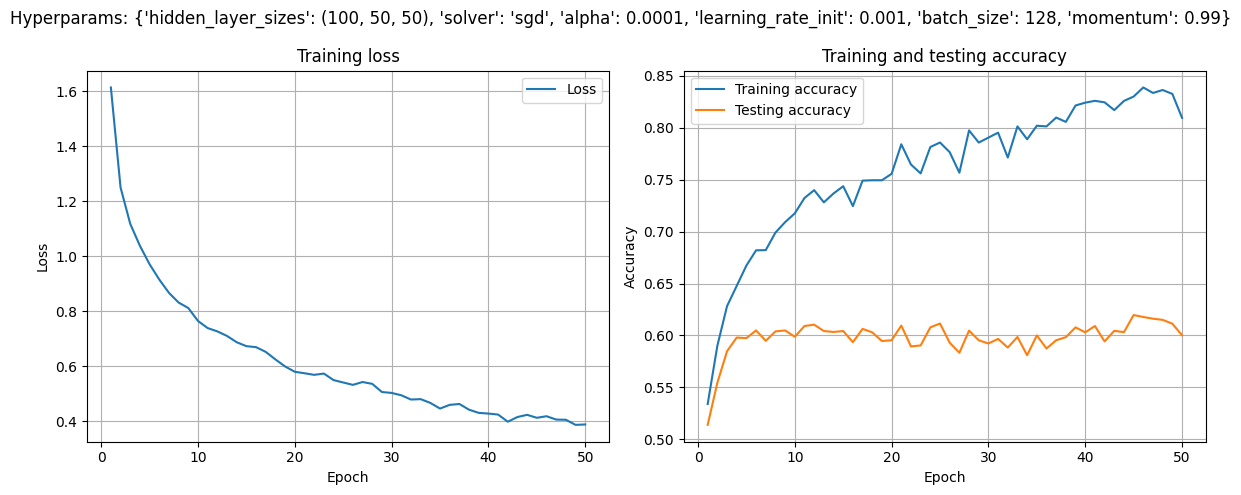

In [18]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

I decided to stay with the previous hyperparameters, which were able to achieve around 0.65 testing accuracy and 0.9 training accuracy.

In [33]:
hyperparam = {
            'hidden_layer_sizes': (100, 100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 64,
            'momentum': 0.8,
            'max_iter'         : 50
            }

classifier, loss, train_acc, test_acc = coc131.q3(hyperparam=hyperparam)
print(classifier)
print(loss)
print(train_acc)
print(test_acc)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.

MLPClassifier(batch_size=64, hidden_layer_sizes=(100, 100), max_iter=1,
              momentum=0.8, random_state=0, solver='sgd', warm_start=True)
[np.float64(1.5467748417557963), np.float64(1.2362128207937235), np.float64(1.12542511956384), np.float64(1.046825133749239), np.float64(0.9855874231585988), np.float64(0.9340883542728287), np.float64(0.8900775298252216), np.float64(0.8509815036585715), np.float64(0.8156025277953389), np.float64(0.7829558200733436), np.float64(0.7524969596699553), np.float64(0.7248537210330147), np.float64(0.6979073352957273), np.float64(0.6733902545188613), np.float64(0.6487916748623588), np.float64(0.625962470934318), np.float64(0.6038004407879598), np.float64(0.5827203036972345), np.float64(0.5629492235395337), np.float64(0.5435444521416058), np.float64(0.5245075964542945), np.float64(0.5067452872132069), np.float64(0.48980509120727306), np.float64(0.4740323364261988), np.float64(0.4584757670828371), np.float64(0.4437094342855604), np.float64(0.4289896497

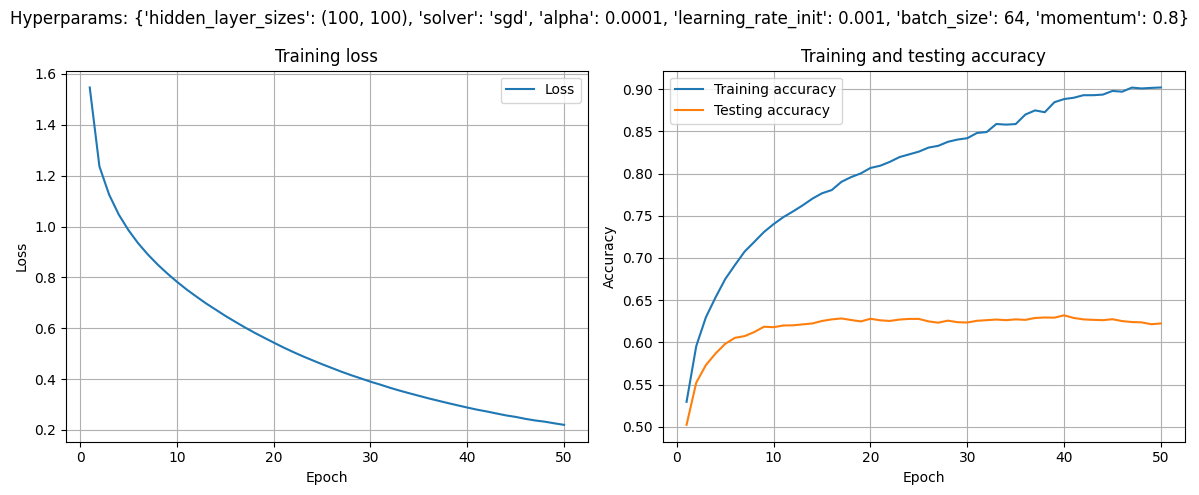

In [34]:
plot_loss_accuracies_graph(loss, train_acc, test_acc, hyperparam)

Overall, I believe that Adam wasn't able to get as high of a test accuracy in this case because it adapts each weight aggressively with the training data, but SGD seems to decrease the loss more steadily, helping it generalise to the testing data.

<h1 style="text-align:center">Q4 - alpha value discovery process</h1>

In [ ]:
#storing the best params found in the class
hyperparam = {
            'hidden_layer_sizes': (100, 100),
            'solver'           : 'sgd',
            'alpha'            : 1e-4,
            'learning_rate_init': 1e-3,
            'batch_size'       : 64,
            'momentum': 0.8,
            'max_iter'         : 50
            }
coc131.best_params = hyperparam
print(coc131.best_params)

{'hidden_layer_sizes': (100, 100), 'solver': 'sgd', 'alpha': 0.0001, 'learning_rate_init': 0.001, 'batch_size': 64, 'momentum': 0.8, 'max_iter': 50}


In [16]:
alpha_results = coc131.q4()

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\datas

## do some explanation here of the graphs

best value of alpha found is 0.5

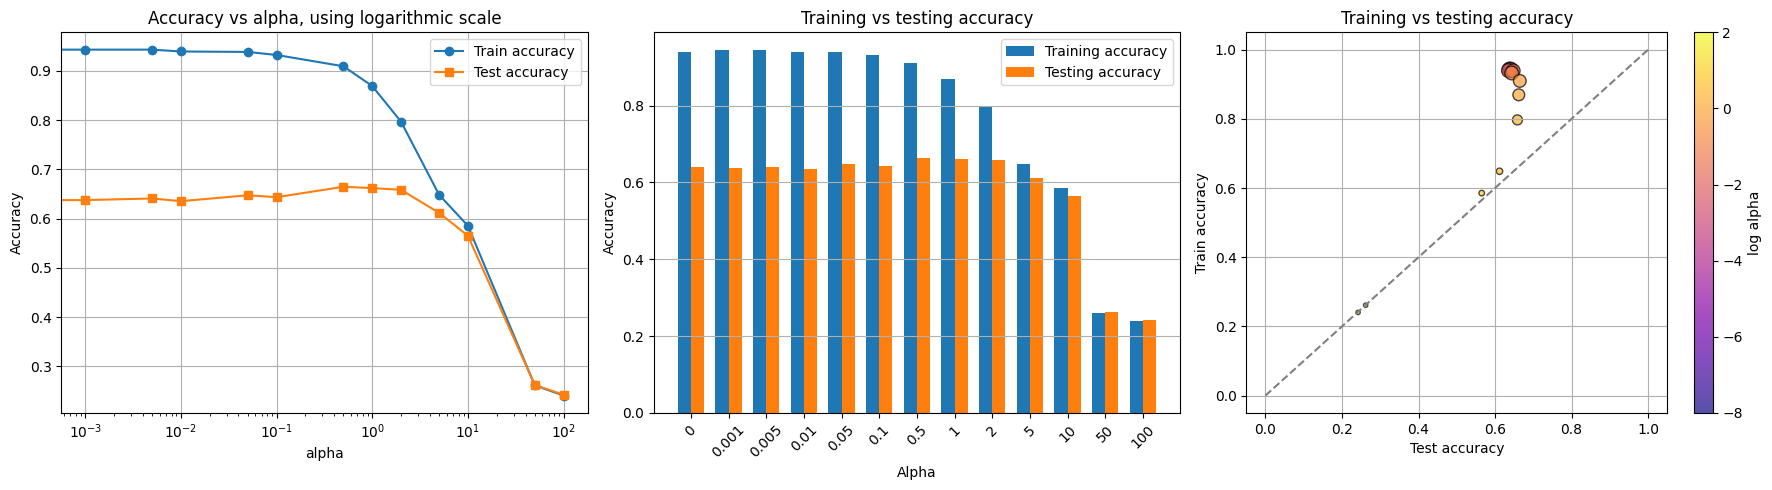

In [27]:
import numpy as np

alphas = np.array([r[0] for r in alpha_results])
train_accuracies = np.array([r[1] for r in alpha_results])
test_accuracies  = np.array([r[2] for r in alpha_results])

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ax = axes[0]
ax.plot(alphas, train_accuracies, marker='o', label='Train accuracy')
ax.plot(alphas, test_accuracies,  marker='s', label='Test accuracy')
ax.set_xscale('log')
ax.set_xlabel('alpha')
ax.set_ylabel('Accuracy')
ax.set_title('Accuracy vs alpha, using logarithmic scale')
ax.legend()
ax.grid(True)

ax = axes[1]
x = np.arange(len(alphas))
width = 0.35
ax.bar(x - width/2, train_accuracies, width, label='Training accuracy')
ax.bar(x + width/2, test_accuracies,  width, label='Testing accuracy')
ax.set_xticks(x)
ax.set_xticklabels([f"{a:.3g}" for a in alphas], rotation=45)
ax.set_xlabel('Alpha')
ax.set_ylabel('Accuracy')
ax.set_title('Training vs testing accuracy')
ax.legend()
ax.grid(True, axis='y')

ax = axes[2]
gaps = train_accuracies - test_accuracies
sc = ax.scatter(
    test_accuracies, train_accuracies,
    s=(gaps*300 + 10),
    c=np.log10(alphas + 1e-8),
    cmap='plasma', alpha=0.7,
    edgecolors='k'
)
ax.plot([0,1],[0,1], '--', color='gray')
ax.set_xlabel('Test accuracy')
ax.set_ylabel('Train accuracy')
ax.set_title('Training vs testing accuracy')
cbar = fig.colorbar(sc, ax=ax)
cbar.set_label('log alpha')
ax.grid(True)

plt.tight_layout()
plt.show()

In [28]:
coc131.best_params['alpha'] = 0.5

In [29]:
coc131.best_params

{'hidden_layer_sizes': (100, 100),
 'solver': 'sgd',
 'alpha': 0.5,
 'learning_rate_init': 0.001,
 'batch_size': 64,
 'momentum': 0.8,
 'max_iter': 50}

# q5

In [30]:
mean_kf, mean_skf, p_value, verdict = coc131.q5()

print(f"KFold mean accuracy: {mean_kf}")
print(f"Stratified mean accuracy: {mean_skf}")
print(f"p-value: {p_value}")
print(verdict)

c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\dataset\.venv\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (50) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\A\VSCodeRepos\datas

KFold mean accuracy: 0.6588148148148149
Stratified mean accuracy: 0.6585185185185185
p-value: 0.9706506423658323
Splitting method had no effect


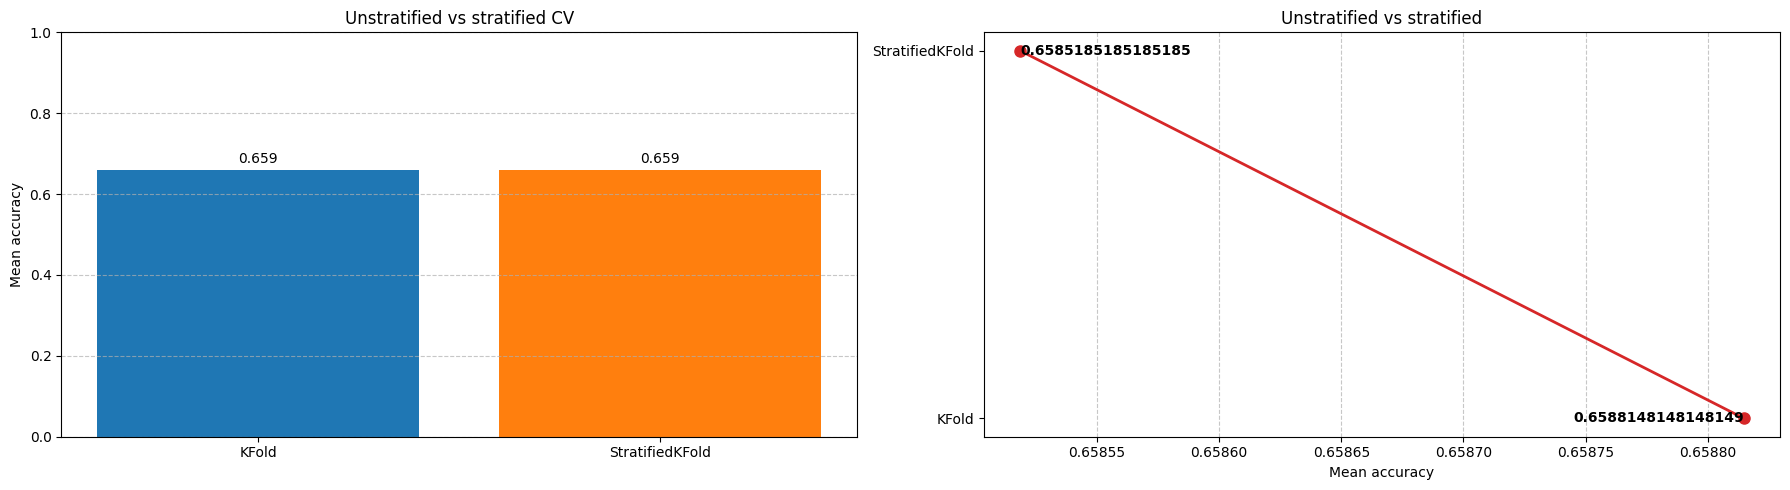

In [40]:
methods = ['KFold', 'StratifiedKFold']
means   = [mean_kf, mean_skf]
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

#bar chart
ax0 = axes[0]
bars = ax0.bar(methods, means, color=['C0','C1'])
ax0.set_ylim(0, 1)
ax0.set_ylabel('Mean accuracy')
ax0.set_title('Unstratified vs stratified CV')
ax0.grid(axis='y', linestyle='--', alpha=0.7)
for bar in bars:
    h = bar.get_height()
    ax0.text(
        bar.get_x() + bar.get_width() / 2, 
        h + 0.01, 
        f'{h:.3f}', 
        ha='center', 
        va='bottom'
    )

#show change between the 2 methods
ax1 = axes[1]
ys = [0, 1]
ax1.plot(means, ys, '-o', color='C3', linewidth=2, markersize=8)
ax1.set_yticks(ys)
ax1.set_yticklabels(methods)
ax1.set_xlabel('Mean accuracy')
ax1.set_title('Unstratified vs stratified')
ax1.grid(axis='x', linestyle='--', alpha=0.7)

for x, y in zip(means, ys):
    align = 'left' if x < max(means) else 'right'
    ax1.text(
        x, 
        y, 
        f'{x}', 
        va='center', 
        ha=align, 
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

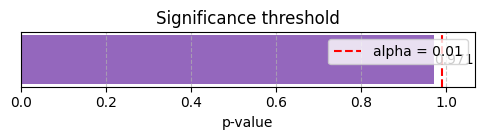

In [42]:
fig, ax = plt.subplots(figsize=(5,1.5))
ax.barh(0, p_value, color='C4')
ax.axvline(0.99, color='red', linestyle='--', label='alpha = 0.01')
ax.set_xlim(0, max(p_value*1.1, 0.1))
ax.set_yticks([])
ax.set_xlabel('p-value')
ax.set_title('Significance threshold')
ax.legend(loc='upper right')
for x in [p_value]:
    ax.text(x + 0.002, 0, f"{x:.3f}", va='center')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


# q6

In [43]:
embedding_results = coc131.q6()


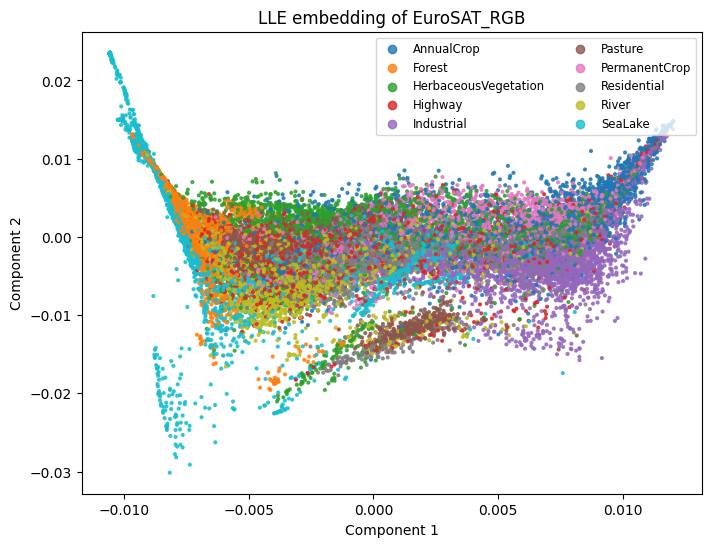

In [55]:
class_names = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway", "Industrial", "Pasture", "PermanentCrop", "Residential", "River", "SeaLake"]

plt.figure(figsize=(8,6))
for idx, cls_name in enumerate(class_names):
    mask = (y == idx)
    plt.scatter(
        embedding_results[mask,0], embedding_results[mask,1],
        s=4, alpha=0.8,
        label=cls_name
    )

plt.scatter(embedding_results[:,0], embedding_results[:,1], c=coc131.y, cmap='tab10', s=4, alpha=0.8)
plt.title("LLE embedding of EuroSAT_RGB")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend(
    loc='upper right',
    markerscale=3,
    fontsize='small',
    ncol=2,
    frameon=True
)
plt.show()

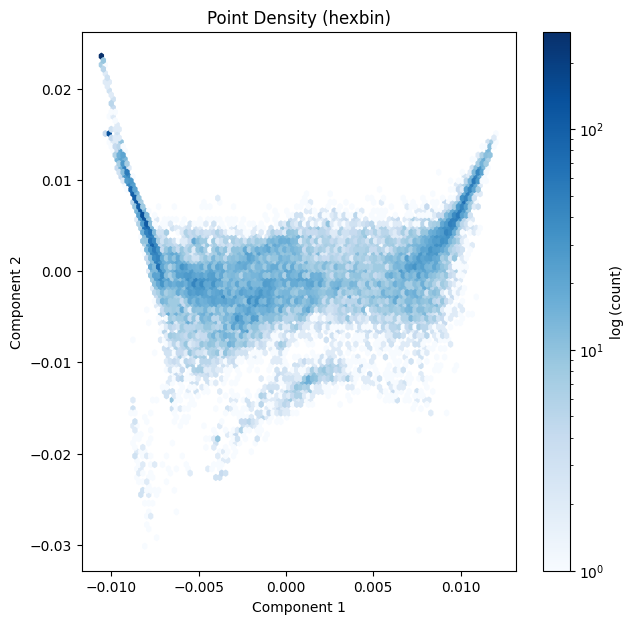

In [56]:
plt.figure(figsize=(7,7))
hb = plt.hexbin(
    embedding_results[:,0],
    embedding_results[:,1],
    gridsize=100,
    cmap='Blues',
    bins='log'
)
plt.title("Point Density (hexbin)")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
cb = plt.colorbar(hb)
cb.set_label("log (count)")
plt.show()


In [59]:
def plot_class_overlap(embedding, labels, class_names, focus_classes):
    """
    embedding:     (N,2) array from q6 (e.g. embedding_results)
    labels:        (N,) int array of class indices (coc131.y)
    class_names:   list of all names in order
    focus_classes: list of class-names you want to highlight
    """
    # Map names to indices
    name_to_idx = {n:i for i,n in enumerate(class_names)}
    focus_idxs  = [name_to_idx[n] for n in focus_classes]

    plt.figure(figsize=(7,7))
    # Plot unfocused classes in light grey
    mask_other = ~np.isin(labels, focus_idxs)
    plt.scatter(
        embedding[mask_other,0],
        embedding[mask_other,1],
        c='lightgray',
        s=4,
        alpha=0.3,
        label='_nolegend_'
    )

    # Plot each focused class in its own color
    for idx in focus_idxs:
        cls_mask = labels == idx
        plt.scatter(
            embedding[cls_mask,0],
            embedding[cls_mask,1],
            s=8,
            alpha=0.8,
            label=class_names[idx]
        )

    plt.title(f"Class overlap: {', '.join(focus_classes)}")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend(markerscale=2, fontsize='small', loc='best')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

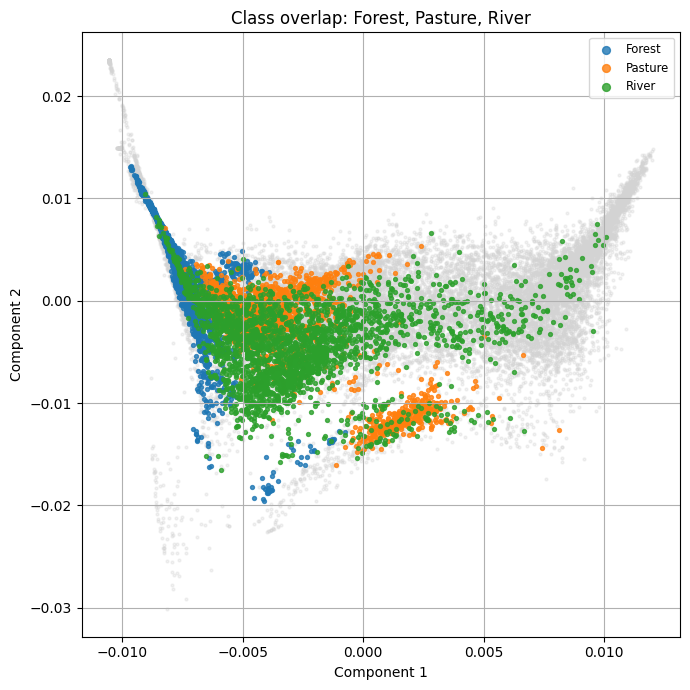

In [60]:
plot_class_overlap(
    embedding_results,
    coc131.y,
    class_names,
    focus_classes=['Forest','Pasture','River']
)